# Terceira Questão

In [103]:
%matplotlib inline
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize
import scipy.stats as stats
from statsmodels.stats.diagnostic import acorr_ljungbox

# Classe de simulação do Modelo de Nível Local

In [116]:
class LocalLevel :
    
    def __init__(self,epsilon = 10,snr = 1):
        
        self.H       = epsilon
        self.Q       = snr*epsilon  
        self.Tshock  = lambda : np.random.normal(0,np.sqrt(epsilon))
        self.Pshock  = lambda : np.random.normal(0,np.sqrt(snr*epsilon))
        self.riccati = epsilon*(snr + np.sqrt(snr*snr + 4*snr))/2
        
    
    def Simulate(self,interactions):
        
        alpha    = np.zeros(interactions)
        alpha[0] = np.random.normal(0,10)
        y        = np.zeros(interactions)
        for t in range(interactions):
            y[t]= alpha[t] + self.Tshock()
            if(t!= interactions - 1):
                alpha[t+1] = alpha[t] + self.Pshock()
        return [y, alpha]
    
    def Filter(self,series):
        
        #Condições iniciais
        a      = np.zeros(len(series))
        P      = np.zeros(len(series))
        F      = np.zeros(len(series))
        K      = np.zeros(len(series))
        L      = np.zeros(len(series))
        inov   = np.zeros(len(series))
        P[0]   = 10**7
        
        for t in range(len(series)):
            # Matriz F, L, K e inovação
            inov[t] = series[t] - a[t] if (not math.isnan(series[t])) else 0
            F[t]    = P[t]      + self.H
            K[t]    = P[t]/F[t]        if (not math.isnan(series[t])) else 0
            L[t]    = 1         - K[t]
            # Passo de Correção
            a[t]    = a[t]      + K[t]*inov[t]
            P[t]    = P[t]*(1 -   K[t])
            # Paso de Atualização
            if(t!= len(series) - 1):
                a[t+1] = a[t]
                P[t+1] = P[t] + self.Q
                
        return{'level' :a, 'variance':P, 'inovations':inov, 'F':F, 'K' :K, 'L':L}
    
    def Smooth(self,series):
        
        Filtering = self.Filter(series)
        F    = Filtering['F']
        invo = Filtering['inovations']
        L    = Filtering['L']
        P    = Filtering['variance']
        a    = Filtering['level']
        K    = Filtering['K']
        r = np.zeros(len(series))
        N = np.zeros(len(series))
        s_a = np.zeros(len(series))
        s_P = np.zeros(len(series))
        
        for t in range(len(series)-1,1,-1):
            r[t-1] = (inov[t]/F[t]) + L[t]*r[t]
            N[t-1] = (1/F[t])       + L[t]*N[t]*L[t]
            s_a[t]   = a[t] + P[t]*r[t-1]
            s_P[t]   = P[t] - P[t]*N[t-1]*P[t]
           
        return{'level' :a, 'variance':P, 'inovations':inov, 'F':F, 'K' :K, 'L':L,'smth_level' : s_a,'smth_var':s_P}
        
    
    def PlotFilter(self,series,ax,confidence = True):
        
        Filtering = self.Filter(series)
        ax.plot(series            , color = (47/255, 105/255, 198/255), label = 'serie' )
        ax.plot(Filtering['level'], color = (63/255, 170/255, 82/255), label = 'nivel filtrado')
        ax.set_title('Serie e Nível Filtrado')
        
        if(confidence):
            up_confidence    = Filtering['level'] + 1.96*np.sqrt(Filtering['variance'])
            down_confidence  = Filtering['level'] - 1.96*np.sqrt(Filtering['variance'])
            x = np.arange(0.0, len(series), 1)
            ax.fill_between(x,up_confidence,down_confidence, facecolor=(63/255, 170/255, 82/255, 170/255))
        ax.legend()
        
    def PlotSmooth(self,series,ax,confidence = True):
        
        Filtering = self.Smooth(series)
        ax.plot(series            , color = (47/255, 105/255, 198/255), label = 'serie' )
        ax.plot(Filtering['smth_level'], color = (206/255, 130/255, 37/255), label = 'nivel suavizado')
        ax.set_title('Serie e Nível Suavizado')
        
        if(confidence):
            up_confidence    = Filtering['smth_level'] + 1.96*np.sqrt(Filtering['smth_var'])
            down_confidence  = Filtering['smth_level'] - 1.96*np.sqrt(Filtering['smth_var'])
            x = np.arange(0.0, len(series), 1)
            ax.fill_between(x,up_confidence,down_confidence, facecolor=(206/255, 130/255, 37/255, 170/255))
        
        ax.legend()
        
        
    def Forecast(self,series ,horizon):
        Filtering = self.Filter(series)
        forecast = np.zeros(len(series)+horizon)
        variance = np.zeros(len(series)+horizon)
        for t in range(len(series)):
            a_next        = Filtering['level'][t]
            P_next        = Filtering['variance'][t] + self.Q
            forecast[t+1] = a_next
            variance[t+1] = P_next + self.H
        for t in range(len(series), len(series) + horizon -1):
            a_next        = forecast[t]
            P_next        = variance[t]   + self.Q
            forecast[t+1] = a_next
            variance[t+1] = P_next + self.H
        
        return forecast, variance
    
    def PlotForecast(self,series,horizon,ax):
        forecast, variance = self.Forecast(series,horizon)
        ax.plot(series  , color = (47/255, 105/255, 198/255), label = 'Serie' )
        ax.plot(forecast, color = (209/255, 29/255, 98/255), label = 'Previsão')
        
        ax.set_title(' Previsão dentro e Fora da amostra')
        up_confidence    = forecast + 1.96*np.sqrt(variance)
        down_confidence  = forecast - 1.96*np.sqrt(variance)
        x = np.arange(0.0, len(series)+horizon, 1)
        ax.fill_between(x,up_confidence,down_confidence, facecolor=(209/255, 29/255, 98/255, 170/255))
        
            
            
    def PlotPconvergence(self,series,ax):
        Filtering = self.Filter(series)
        ES        = np.full( len(series) , self.riccati)
        ax.plot(ES,label = 'Solução estacionária')
        ax.plot(Filtering['variance'] ,label = 'Variancias estimadas')
        ax.set_title('Convergência da Variância')
        ax.legend()
        return ES
    
    def Likelihood(self,series,q):
        
        #Condições iniciais
        n = len(series)
        a    = np.zeros(n-1)
        a[0] = series[0]
        P    = np.zeros(n-1)
        P[0] = 1 + q
        F    = np.zeros(n-1)
        inov = np.zeros(n-1)
        _series = series[1:]
        
        for t in range(n-1):
            # Matriz F, L, K e inovação
            inov[t] = _series[t] - a[t] if (not math.isnan(series[t])) else 0
            F[t]    = P[t]      +   1
            K       = P[t]/F[t]        if (not math.isnan(series[t])) else 0
            # Passo de Correção
            a[t]    = a[t]      + K*inov[t]
            P[t]    = P[t]*(1 -   K)
            # Paso de Atualização
            if(t!= n - 2):
                a[t+1] = a[t]
                P[t+1] = P[t] + q
                
        _epsilon  = (1/(n-1))*sum((inov*inov)/F)
        lldc      = -((n-1)/2)*np.log(_epsilon) - 0.5*sum(np.log(F))
        return lldc
    
    def epsilon(self,q):
        
        #Condições iniciais
        n = len(series)
        a    = np.zeros(n-1)
        a[0] = series[0]
        P    = np.zeros(n-1)
        P[0] = 1 + q
        F    = np.zeros(n-1)
        inov = np.zeros(n-1)
        _series = series[1:]
        
        for t in range(n-1):
            # Matriz F, L, K e inovação
            inov[t] = _series[t] - a[t] if (not math.isnan(series[t])) else 0
            F[t]    = P[t]      +   1
            K       = P[t]/F[t]        if (not math.isnan(series[t])) else 0
            # Passo de Correção
            a[t]    = a[t]      + K*inov[t]
            P[t]    = P[t]*(1 -   K)
            # Paso de Atualização
            if(t!= n - 2):
                a[t+1] = a[t]
                P[t+1] = P[t] + q
                
        _epsilon  = (1/(n-1))*sum((inov*inov)/F)
        return _epsilon
    
    def OptimalParams(self,series,start):
        ll  = lambda psi : - self.Likelihood(series,np.exp(psi))
        res = minimize(ll, start)
        q   = np.exp(res['x'])
        eps = self.epsilon(q)
        return eps,q
        
    def UpdateParams(self,epsilon,snr):
        self.H       = epsilon
        self.Q       = snr*epsilon
        
    def StandartResiduals(self,series):
        Filtering = self.Filter(series)
        F = Filtering['F']
        F = F[1:]
        inov = Filtering['inovations']
        inov = inov[1:]
        return inov/np.sqrt(F)
    
    def ShowResidualStatistics(self,series):
        
        e = self.StandartResiduals(series)
        fig, axs = plt.subplots(1,2)
        fig.set_size_inches(16, 4)
        axs[1].set_title('Distribuição')
        axs[0].set_title('Evolução')
        sns.distplot(e,ax=axs[1])
        sns.tsplot(e,ax=axs[0])
        
        fig, axs = plt.subplots(1,2)
        axs[1].set_title('Correlograma')
        axs[0].set_title('QQ plot')
        fig.set_size_inches(16, 4)
        a = plt.acorr(inov[3:])
        a = stats.probplot(e, dist="norm", plot = axs[0])
    
    
    def DiagnosticTests(self,e):
        n = len(e)
        m1  = (1/n)*sum(e)
        _m1 = np.full(n,m1)
        _e  = e - _m1
        m2 = (1/n)*sum(_e*_e)
        m3 = (1/n)*sum(_e*_e*_e)
        m4 = (1/n)*sum(_e*_e*_e*_e)
        S  = m3/np.sqrt(m2*m2*m2)
        K  = m4/(m2*m2)
        N  = n*( ((S*S)/6) + ((K-3)*(K-3)/24) )
        h  = int(n/2)
        H  = sum(e[h:]*e[h:])/sum(e[:n-h]*e[:n-h])
        res = acorr_ljungbox(e, lags= 20, boxpierce=False)
        Q  =res[0][8]
        Result = 'S = {:.2f} , K = {:.2f} , N = {:.2f} , H({:d}) = {:.2f} , Q({:d}) = {:.2f}'.format(S,K,N,h,H,9,Q)
        print(Result)

In [132]:
ll = LocalLevel(500,0.01)
simulation = ll.Simulate(100)
series     = simulation[0]
real       = simulation[1]

# Primeira Parte : Simulação

In [118]:
def PlotSimulations(ax,sigma,snr,nr_of_simulations):
    ll = LocalLevel(sigma,snr)
    series_dict = { 'simulation ' + str(i) : ll.Simulate(300)[0] for i in range(nr_of_simulations)}
    df = pd.DataFrame(series_dict)
    ax.set_title('Epsilon = ' + str(sigma) + ' snr = ' + str(snr))
    df.plot(ax = ax)

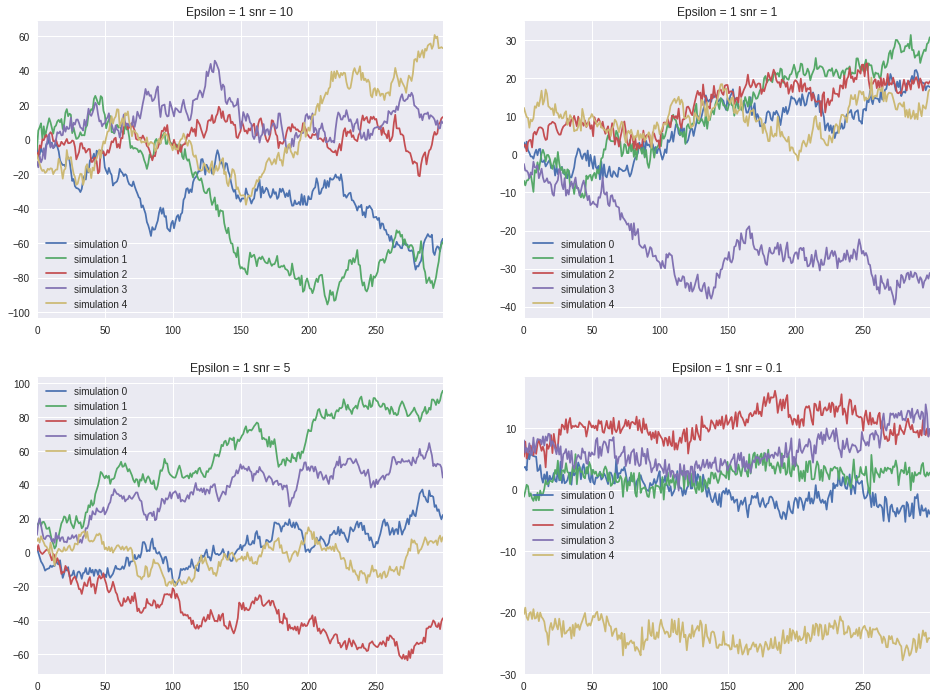

In [119]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(16, 12)
PlotSimulations(axs[0][0],1,10,5)
PlotSimulations(axs[1][0],1,5,5)
PlotSimulations(axs[0][1],1,1,5)
PlotSimulations(axs[1][1],1,0.1,5)

# Segunda Parte : Filtragem das Componentes

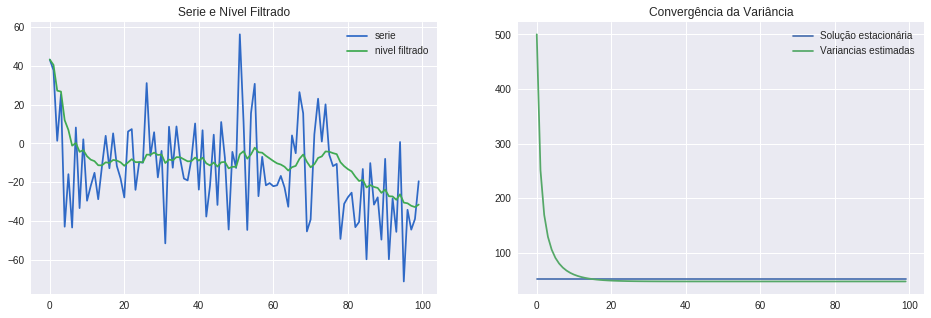

In [140]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(16, 5)
ll.PlotFilter(series, axs[0], confidence = False)
R = ll.PlotPconvergence(series,axs[1])

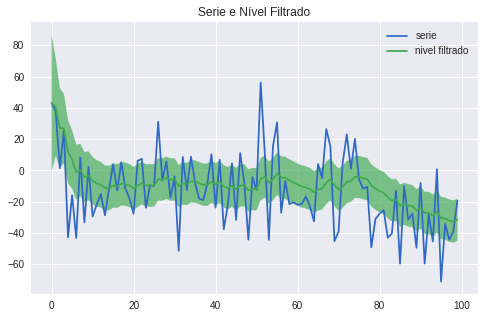

In [141]:
fig, axs = plt.subplots(1,1)
fig.set_size_inches(8, 5)
ll.PlotFilter(series,axs)

## Análise das inovações

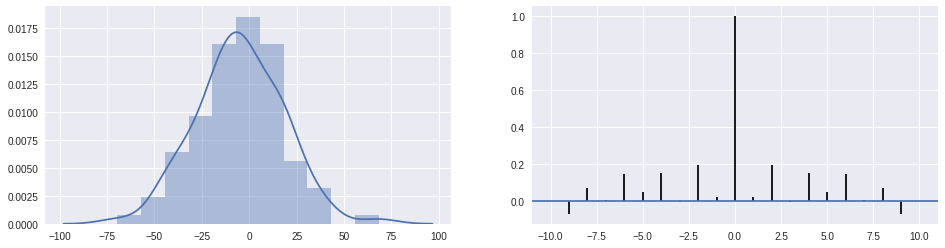

In [142]:
Filtering = ll.Filter(series)
inov = Filtering['inovations']
fig, axs = plt.subplots(1,2)
fig.set_size_inches(16, 4)
sns.distplot(inov[1:], ax =axs[0])
a = plt.acorr(inov[1:], )

# Terceira Parte : Suavização

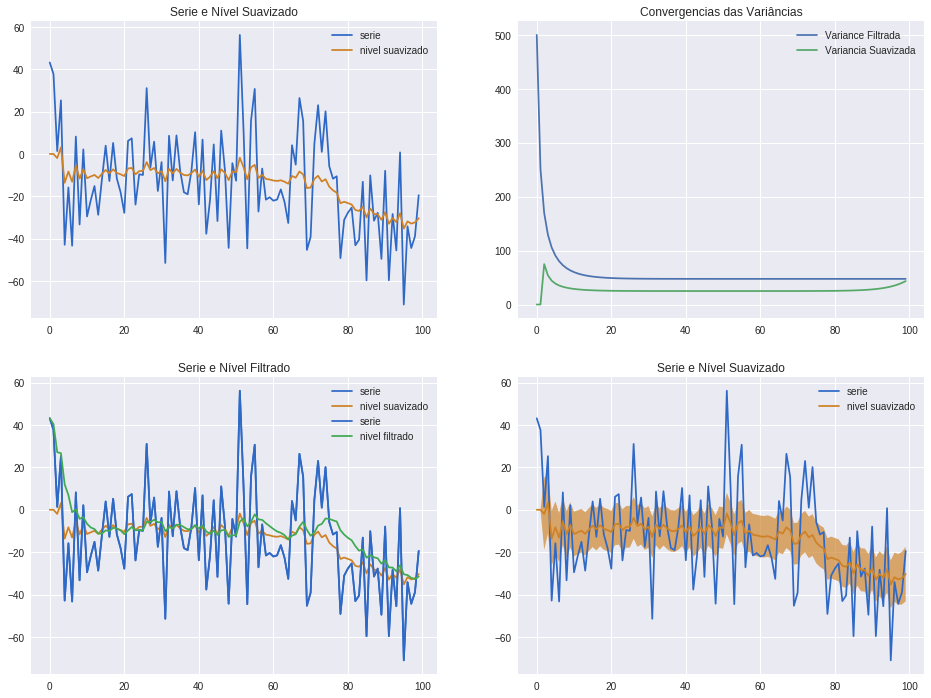

In [144]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(16, 12)
ll.PlotSmooth(series,ax =axs[0][0], confidence = False)
ll.PlotSmooth(series,ax =axs[1][0], confidence = False)
ll.PlotFilter(series,ax =axs[1][0], confidence = False)

Filtering = ll.Smooth(series)
axs[0][1].plot(Filtering['variance'] , label = 'Variance Filtrada'  )
axs[0][1].plot(Filtering['smth_var'] , label = 'Variancia Suavizada')
axs[0][1].set_title('Convergencias das Variâncias')
axs[0][1].legend()

ll.PlotSmooth(series,axs[1][1])

## Tratamento de Observações Faltantes

In [145]:
series[43] = None
series[44] = None
series[45] = None
series[50] = None
series[71] = None
series[72] = None

## Série e Estimativa Filtrada

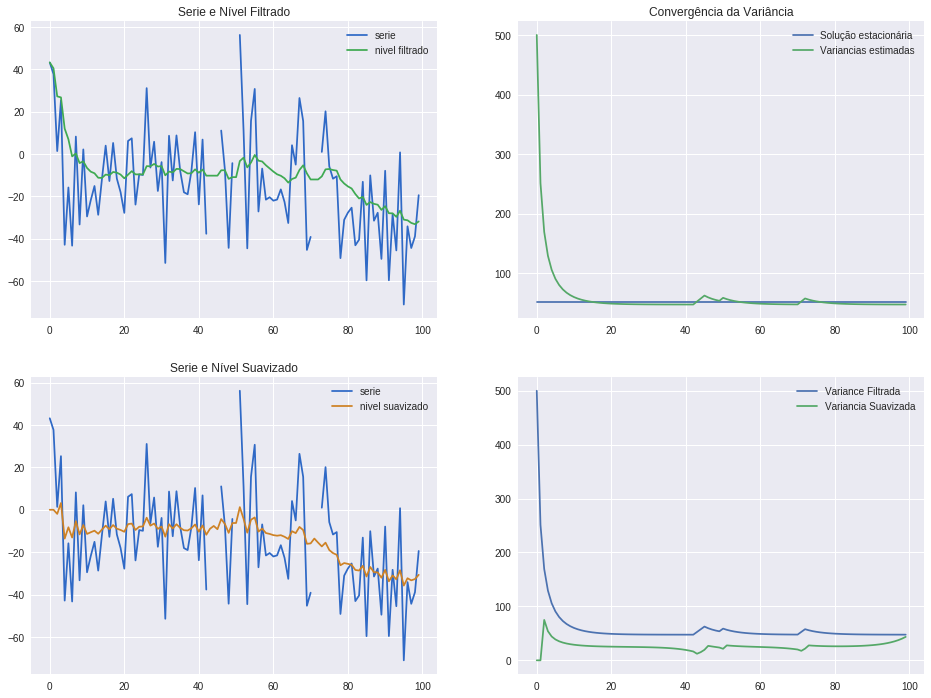

In [146]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(16, 12)
ll.PlotFilter(series, axs[0][0],confidence = False)
R = ll.PlotPconvergence(series, axs[0][1])
ll.PlotSmooth(series, axs[1][0] ,confidence = False)

Filtering = ll.Smooth(series)
axs[1][1].plot(Filtering['variance'] , label = 'Variance Filtrada'  )
axs[1][1].plot(Filtering['smth_var'] , label = 'Variancia Suavizada')
axs[1][1].legend()

# Previsões

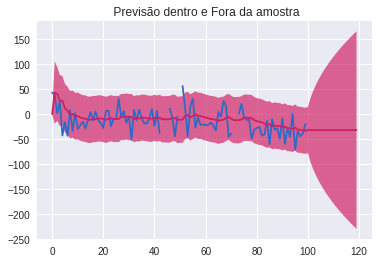

In [147]:
fig, axs = plt.subplots(1,1)
ll.PlotForecast(series,20,axs)

# Máxima Verossimilhança

## Log-Likelihood Difusa e concentrada :
$$ \log{\mathbf{L}_{dc}} = - \frac{n}{2}\log{2\pi} - \frac{n-1}{2} - \frac{n-1}{2}\log{\overset{\wedge}{\sigma_{\epsilon}^{2}}} - \frac{1}{2}\sum_{2}^{n}\log{\mathbf{F}_{t}^{\star}} $$
onde 
$$ \overset{\wedge}{\sigma_{\epsilon}^{2}} = \frac{1}{n-1}\sum_{2}^{n}\frac{\nu^{2}}{\mathbf{F}_{t}^{\star}} $$

In [133]:
start = -100
print(ll.OptimalParams(series,start))
start = -10
print(ll.OptimalParams(series,start))
start = -1
print(ll.OptimalParams(series,start))
start = 0
print(ll.OptimalParams(series,start))
start = 1
print(ll.OptimalParams(series,start))
start = 10
print(ll.OptimalParams(series,start))
start = 100
print(ll.OptimalParams(series,start))

(566.6991275711888, array([  3.72007598e-44]))
(458.87014565053101, array([ 0.01713243]))
(458.86985107255265, array([ 0.01713261]))
(458.86996737840332, array([ 0.01713254]))
(458.87005819381216, array([ 0.01713248]))
(566.6991275711888, array([  2.05281669e-20]))
(3.5002728971956938e-41, array([  2.68811714e+43]))


## Valores ótimos encontrados : $\sigma_{\epsilon}$ = 458   e  snr  = 0.0171

In [136]:
estimated = LocalLevel(458,0.0171)

## Valor real e nível Filtrado com parâmetros ótimos

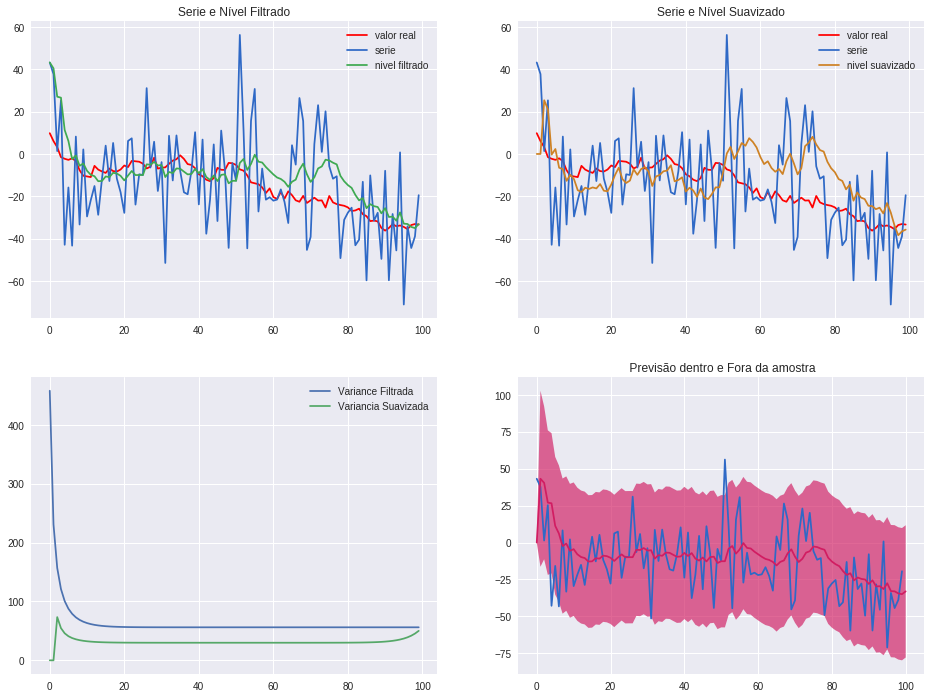

In [137]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(16, 12)

axs[0][0].plot(simulation[1], label = 'valor real', color = (1,0,0))
estimated.PlotFilter(series,axs[0][0], confidence = False)

axs[0][1].plot(simulation[1], label = 'valor real', color = (1,0,0))
estimated.PlotSmooth(series,axs[0][1], confidence = False)

Filtering = estimated.Smooth(series)
axs[1][0].plot(Filtering['variance'] , label = 'Variance Filtrada'  )
axs[1][0].plot(Filtering['smth_var'] , label = 'Variancia Suavizada')
axs[1][0].legend()

estimated.PlotForecast(series,1,axs[1][1])

## Testes e Diagnósticos

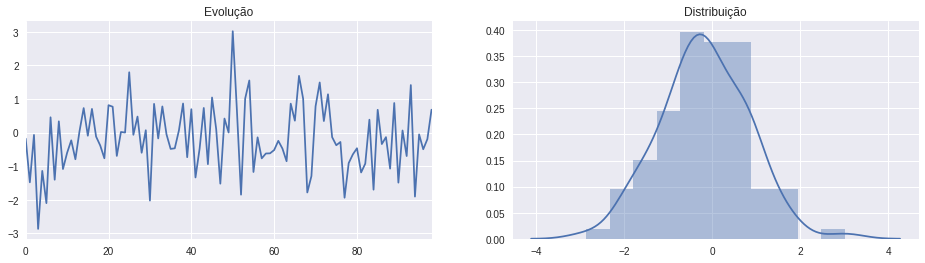

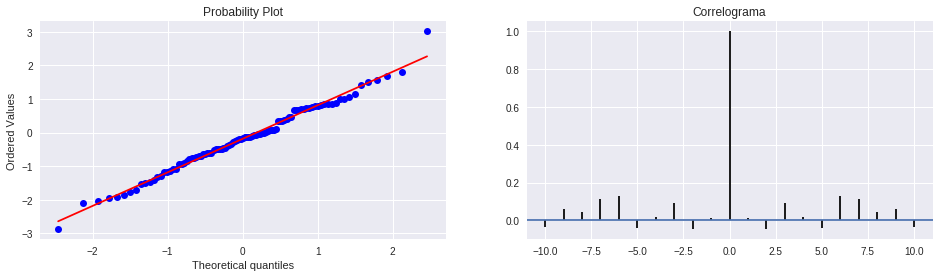

In [138]:
estimated.ShowResidualStatistics(series)

In [139]:
e = estimated.StandartResiduals(series)
estimated.DiagnosticTests(e)

S = 0.10 , K = 3.37 , N = 0.75 , H(49) = 1.33 , Q(9) = 6.50
